# Variational Autoencoder

変分オートエンコーダ  
変分は変分法の変分。

潜在変数に任意の確率分布を指定できるオートエンコーダ。decoder部分を生成モデルとして使いやすくなる。

<br>

潜在変数に標準正規分布を仮定し、MNISTの画像を生成する。

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import display
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def write(model, n_images, width=512):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y, _, _ = model(x)
    x = x.view(n_images, 1, 28, 28).cpu()
    y = y.view(n_images, 1, 28, 28).cpu()
    f = width // n_images
    x = transforms.Resize((f))(x)
    y = transforms.Resize((f))(y)
    grid = torchvision.utils.make_grid(torch.cat([x, y], dim=0), nrow=n_images)
    img = transforms.functional.to_pil_image(grid)
    display(img)

## ネットワーク構築

普通のオートエンコーダと異なる点がいくつかある

- encoderが出力する値は、潜在変数そのものではなく、潜在変数が従う確率分布のパラメータとする
- 今回は確率分布に正規分布を指定しているため、**平均**と**分散**の2種類の値を潜在変数の次元数分出力する
- encoderが出力したパラメータに従って乱数を生成し、decoderに与える
- 普通に乱数を生成すると逆伝播ができないので、少し工夫をして生成する。具体的には以下の流れに従う
    - 標準正規分布に従って乱数を生成
    - 分散を掛ける
    - 平均に足す

In [3]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        z_mean, z_log_var = z[:, :self.z_dim], z[:, self.z_dim:]
        z = self.reparameterize(z_mean, z_log_var)
        y = self.decoder(z)
        return y, z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        eps = torch.randn_like(z_log_var)
        z = z_mean + torch.exp(z_log_var / 2) * eps
        return z

## 損失関数

これをどう定義するかがポイント。

学習の目的を考えてみる。
- 入力と出力の差を最小化する
- 潜在変数が標準正規分布に従うようにする

### 単純な損失関数

誰でもぱっと思いつきそうなことをやってみる。ただ、恐らくこれは一般的なやり方ではない。

以下のような損失関数を定義する。

$$
E = \frac{1}{N} \sum_i (x_i - y_i)^2 + \frac{1}{D} \sum_i \left( (0 - \mu_i)^2 + (1 - \sigma_i)^2 \right)
$$

- $N$: 入出力の次元数
- $D$: 潜在変数の次元数
- $\mu$: 潜在変数の平均
- $\sigma$:  潜在変数の分散

入出力、平均、分散の差の平均二乗誤差をとっているだけ。  
これを小さくするためには、入出力の差を小さくし、平均を0、分散を1に近づける必要がある。

In [24]:
MSE = nn.MSELoss()
class SimpleLossFunc:
    def __init__(self, z_dim, onry_xy=False):
        self.z_dim = z_dim
        self.onry_xy = onry_xy

    def __call__(self, y, x, z_mean, z_log_var):
        zeros = torch.zeros_like(z_mean)
        ones = torch.ones_like(z_log_var)
        loss_xy = MSE(y, x)
        loss_mean = MSE(z_mean, zeros)
        loss_log_var = MSE(torch.exp(z_log_var), ones)
        loss = loss_xy + (not self.onry_xy) * (loss_mean + loss_log_var)
        return loss

### 一般的な損失関数

In [15]:
def loss_func(y, x, z_mean, z_log_var):
    return

## 学習

In [16]:
def train(model, dataloader, optimizer, loss_func, epoch):
    model.train()
    for epoch in range(1, epoch + 1):
        for (x, _) in dataloader:
            optimizer.zero_grad()
            x = x.view(-1, 784).to(device)
            y, z_mean, z_log_var = model(x)
            loss = loss_func(y, x, z_mean, z_log_var)
            loss.backward()
            optimizer.step()
        print(f'{epoch}epoch loss: {loss.item()}')

In [26]:
z_dim = 20
vae = VAE(z_dim).to(device)
lf = SimpleLossFunc(z_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
train(vae, dataloader, optimizer, lf, 5)

1epoch loss: 0.06896277517080307
2epoch loss: 0.06686560064554214
3epoch loss: 0.06484309583902359
4epoch loss: 0.06665585190057755
5epoch loss: 0.06774736940860748


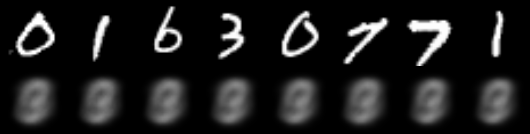

In [27]:
write(vae, 8)

微妙

In [28]:
z_dim = 20
vae = VAE(z_dim).to(device)
lf = SimpleLossFunc(z_dim, onry_xy=True)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
train(vae, dataloader, optimizer, lf, 5)

1epoch loss: 0.024316590279340744
2epoch loss: 0.012879344634711742
3epoch loss: 0.013501984067261219
4epoch loss: 0.010720841586589813
5epoch loss: 0.010974363423883915


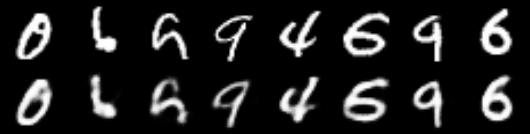

In [29]:
write(vae, 8)

パラメータ部分を消すとできるね